In [1]:
import gym
from gym import spaces
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import time

In [9]:
########### variables #########
BALANCE = 1000
TRANSACTION_COST = 0.2/100 # pourcentage
SIMULATION_DURATION = "20s"
TIMESTEP = 1
MARGIN_RATE = 0.02
LEVERAGE = 1
PRICE = 1.2
VOLATILITY = volatility = 0.01/100
TRANSACTION_UNIT = 1000
TEXT = False
###############################

In [31]:
class EnvTest2(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, balance=BALANCE, transaction_cost=TRANSACTION_COST, simulation_duration=SIMULATION_DURATION,
                 timestep=TIMESTEP,margin_rate=MARGIN_RATE, leverage=LEVERAGE, price=PRICE,
                 volatility=VOLATILITY, transaction_unit=TRANSACTION_UNIT, text=TEXT):
        self.starting_balance = balance # valeur du porte feuille
        self.transaction_cost = transaction_cost
        self.simulation_duration = simulation_duration # durée de la simulation demandées
        self.timestep = timestep # simulation sur un pas de 1 seconde
        self.margin_rate = margin_rate
        self.leverage = leverage
        self.price = price
        self.volatility = volatility
        self.transaction_unit= transaction_unit
        self.text = text
        self.max_time = self.timeConverter(self.simulation_duration) # temps maximum d'un épisode
        
        self.action_spaces = spaces.Discrete(5) # 0: achat, 1: vente de l'achat, 3: rien faire, 4 : short, 5:vendre le short
        self.observation_spaces = spaces.Box(low=0,
                                           high=np.inf,
                                           shape=(1,),
                                           dtype=np.float32)
        
        np.set_printoptions(precision=5)
        self.reset()
        
    def step(self, action):
        """effectue un 'step' dans la simulation"""
        done = False
        self.current_portfolio_profit = 0
        self.actionProcessing(action)
           
        
        self.current_time += self.timestep
        
        if self.current_time >= self.max_time:
            done = True
            print(f"len price history : {len(self.price_history)}")
            print(f"len profit and loss : {len(self.profit_and_loss_history)}")
            """for i in range(20):
                print(f"eur/usd : {self.price_history[i]}")
                print(f"P/L : {self.profit_and_loss_history[i]}")
                print()"""
                
        self.calculateProfitAndLoss()
        self.simulateNextPrice()
        next_state = self.getObservations()
        reward = self.getReward(action)
        info = {}
        return next_state, reward, done, info
    
                      
    def reset(self):
        """Reinitialise les variables modifiable"""
        
        # Reset variables
        self.current_time = 0
        self.current_price = self.price
        self.current_balance = self.starting_balance
        self.current_profit_and_loss = 0
        self.current_portfolio_profit = 0
        
        self.nb_long_position = 0
        self.nb_short_position = 0
        
        # History management
        self.price_history = []
        self.savePriceHistory()
        self.balance_history = []
        self.saveBalanceHistory()
        
        self.long_history = []
        self.short_history = []
        self.profit_and_loss_history = []
        self.calculateProfitAndLoss()
        
        self.long_buy_plot = []
        self.long_sell_plot = []
        self.short_buy_plot = []
        self.short_sell_plot = []
        
        next_state = self.getObservations()
        return next_state
        
    def render(self):
        # Define a function thath displays the environment
        fig, axes = plt.subplots(3,1, figsize = (12, 6), dpi = 200)
        fig.subplots_adjust(hspace=0.4) 

        axes[0].plot(self.price_history)
        axes[0].set_ylabel("EUR/USD")
        axes[0].set_title("EUR/USD simulé*")
        axes[1].plot(self.profit_and_loss_history)
        axes[1].set_ylabel("EUR")
        axes[1].set_title("Profit & Loss")
        axes[2].plot(self.balance_history)
        axes[2].set_ylabel("EUR")
        axes[2].set_title("Valeur du porte-feuille")
        axes[2].set_xlabel("Secondes")
        
        max_len = max(len(liste) for liste in [self.long_buy_plot, self.long_sell_plot, self.short_buy_plot, self.short_sell_plot])
            
        for i in self.long_buy_plot:
            axes[0].plot([i,], [self.price_history[i]], marker="^", color="green", markersize=8, markeredgewidth=1)
            
        for i in self.long_sell_plot:
            axes[0].plot([i,], [self.price_history[i]], marker="x", color="green", markersize=8, markeredgewidth=1)
            
        for i in self.short_buy_plot:
            axes[0].plot([i,], [self.price_history[i]], marker="v", color="red", markersize=8, markeredgewidth=1)
            
        for i in self.short_sell_plot:
            axes[0].plot([i,], [self.price_history[i]], marker="x", color="red", markersize=8, markeredgewidth=1)
    
    
    
    # Méthods that allow to save the histories   
    def savePriceHistory(self):
        """Define a function thath logs the prices"""
        self.price_history.append(self.current_price)
    
    def saveBalanceHistory(self):
        """Define a function thath logs the balance"""
        self.balance_history.append(self.current_balance)
        
    def saveLongHistory(self, long, margin):
        """Define a function thath logs longs"""
        self.long_history.append((long, margin))
    
    def saveShortHistory(self, short, margin):
        """Define a function thath logs shorts"""
        self.short_history.append((short, margin))
        
    def saveProfitAndLoss(self, profit_and_loss):
        """Define a function thath logs the profits & losses"""
        self.profit_and_loss_history.append(profit_and_loss)
    
    
    
    # Methods that allow to manage price simulation
    def updateVolatility(self):
        """Define a function to update the volatility""" 
        return rnd.uniform(0.005, 0.02/100)
       
    def jumpDiffusion(self):
        """Define a function to calculate the jump size based on jump diffusion model"""
        lambda_j = 0.001
        mu_j = -0.1/5
        sigma_j = 0.1/100
        jump = 0
        if rnd.uniform(0, 1) < lambda_j:
            jump = rnd.normalvariate(mu_j, sigma_j)
        return jump
  
    def simulateNextPrice(self):
        """Define a function that generates the next price"""
        # Calculate the next price as a random walk with jumps
        jump = self.jumpDiffusion()
        volatility = self.updateVolatility()
        self.current_price += rnd.normalvariate(0, volatility) + jump
        self.savePriceHistory()

        
        
    # Méthods to calculate transaction_cost, le P&L, etc      
    def calculateProfitAndLoss(self):
        total_PL = 0
        if len(self.long_history) > 0: # check l'historique des achats    
            for e in self.long_history:
                total_PL += (self.current_price - (e[0]*(1+self.transaction_cost))) * self.transaction_unit
                
        if len(self.short_history) > 0:
            for f in self.short_history:
                total_PL += -(self.current_price - (f[0]*(1+self.transaction_cost))) * self.transaction_unit

        self.profit_and_loss_history.append(round(total_PL, 2))   
        #print(f"Current P&L : {self.profit_and_loss_history[-1]}")
        #print()
    def calculateLongPL(self, long):
        return (self.current_price - (long[0]*(1+self.transaction_cost))) * self.transaction_unit
    
    def calculateShortPL(self, short):
        return -(self.current_price - (short[0]*(1+self.transaction_cost))) * self.transaction_unit
    
    
    
    
    # Methods that allow to manage the different actions of the agent
    def actionProcessing(self, action):
        if action == 0 or action == 1: # long management
            self.long(action)
        elif action == 2: # ne rien faire
            pass
        elif action == 3 or action == 4: # vendre le short
            self.short(action)
        
        self.saveBalanceHistory()
    
    def long(self, action):
        """Define a function that manage longs"""
        margin_requirement = round(self.transaction_unit * self.current_price * self.margin_rate, 2)
        
        if action == 0: # acheter une position
            if self.current_balance > margin_requirement:
                self.saveLongHistory(self.current_price, margin_requirement)
                self.current_balance -= margin_requirement
                self.nb_long_position += 1
                self.long_buy_plot.append(self.current_time)
                if self.text:
                    print(f"Bought {self.transaction_unit} contract(s)  at {round(self.current_price,5)}")
                    print(f"Balance : {round(self.current_balance,2)}€")                                   
            elif self.text:
                print(f"Not enough balance to make the purchase.")
                
        elif action == 1: # revendre une position
            if self.nb_long_position > 0:
                long_profit_and_margin = self.long_history.pop(0)
                profit = self.calculateLongPL(long_profit_and_margin)
                margin = long_profit_and_margin[1]
                
                self.current_balance += profit + margin
                self.current_portfolio_profit = round(profit + margin, 2)

                self.nb_long_position -= 1
                self.long_sell_plot.append(self.current_time)
            elif self.text:
                print(f"You have no open positions")
                
        if self.text:
            print("----")
            print()
        
              
    def short(self, action):
        """Define a function that manage longs"""
        margin_requirement = round(self.transaction_unit * self.current_price * self.margin_rate, 2)        
        
        if action == 3: # short une position
            if self.current_balance > margin_requirement:
                self.saveShortHistory(self.current_price, margin_requirement)
                self.current_balance -= margin_requirement
                self.nb_short_position += 1
                self.short_buy_plot.append(self.current_time)
                if self.text:
                    print(f"Shorted {self.transaction_unit} contract(s)  at {round(self.current_price,5)}")
                    print(f"Balance : {round(self.current_balance,2)}€")  
                elif self.text:
                    print(f"Not enough balance to make the short.")
        elif action == 4: # vendre le short
            if self.nb_short_position > 0:
                short_profit_and_margin = self.short_history.pop(0)
                profit = self.calculateShortPL(short_profit_and_margin)
                margin = short_profit_and_margin[1]
                
                self.current_balance += profit + margin
                self.current_portfolio_profit = round(profit + margin, 2)

                self.nb_short_position -= 1
                self.short_sell_plot.append(self.current_time)
            elif self.text:
                print(f"You have no open positions")
        
        if self.text:
            print("----")
            print()
   


    # Methods to manage data for the agent, observations and rewards
    def getObservations(self):
        """Observations management"""
        obs_1 = self.price_history[-1] ## Valeur actuelle de la courbe/last value de l'histo
        obs_2 = self.balance_history[-1]
        return np.array([obs_1, obs_2])

    def getReward(self, action):
        """Rewards management"""
        print(f"action reward n°{action}")
        if action == 0 or action == 2 or action == 3:
            return -1
        else:
            return self.current_portfolio_profit

    
    
    
    # Methods to manage manual simulation time
    def timeConverter(self, time):
        """Convert manual duration
        Return the maximum duration in seconds (or depanding on the time step)"""
        number = ""
        value = ""
        for string in time:
            if string.isdigit():
                number += string
            else:
                value += string
        if not self.translate(value):
            print("Incorrect simulation duration...")
            exit() # ajouter la gestion de mauvaises données
        time_converted = int(number) * self.translate(value)
        return time_converted
    
    def translate(self, value):
        """function that translate 'str' and returns the value in seconds"""
        
        ## Time constant in seconds
        SECONDE = 1.0
        MINUTE = 60.0
        HOUR = 60.0 * MINUTE
        DAY = 24.0 * HOUR
        WEEK = 7.0 * DAY
        MONTH = 30.0 * DAY
        YEAR = 365.0 * DAY
        
        d = {SECONDE : ["s", "seconde", "secondes", "sec", "secs"],
            MINUTE : ["m", "min", "minute", "minutes", "mins", "minutes"],
            HOUR : ["h", "heure", "hour", "hours", "heures"],
            DAY : ["d", "j", "jour", "day", "jours"],
            WEEK : ["w", "week", "semaine", "weeks", "semaines"],
            YEAR : ["y", "year", "année", "annee", "an", "années", "years"]
            }

        
        d_inv = {}
        for k, v in d.items():
            for i in v:
                d_inv.update({i: k})
        return d_inv.get(value.lower())
                


env observation spaces : (1,)
env action spaces : 5

state : [   1.2 1000. ]
action reward n°4
reward : 0
action reward n°2
reward : -1
action reward n°4
reward : 0
action reward n°2
reward : -1
action reward n°4
reward : 0
action reward n°0
reward : -1
action reward n°2
reward : -1
action reward n°3
reward : -1
action reward n°2
reward : -1
action reward n°3
reward : -1
action reward n°4
reward : 28.03
action reward n°1
reward : 13.16
action reward n°0
reward : -1
action reward n°1
reward : 20.98
action reward n°4
reward : 39.86
action reward n°0
reward : -1
action reward n°1
reward : 17.07
action reward n°4
reward : 0
action reward n°2
reward : -1
len price history : 20
len profit and loss : 20
action reward n°1
reward : 0


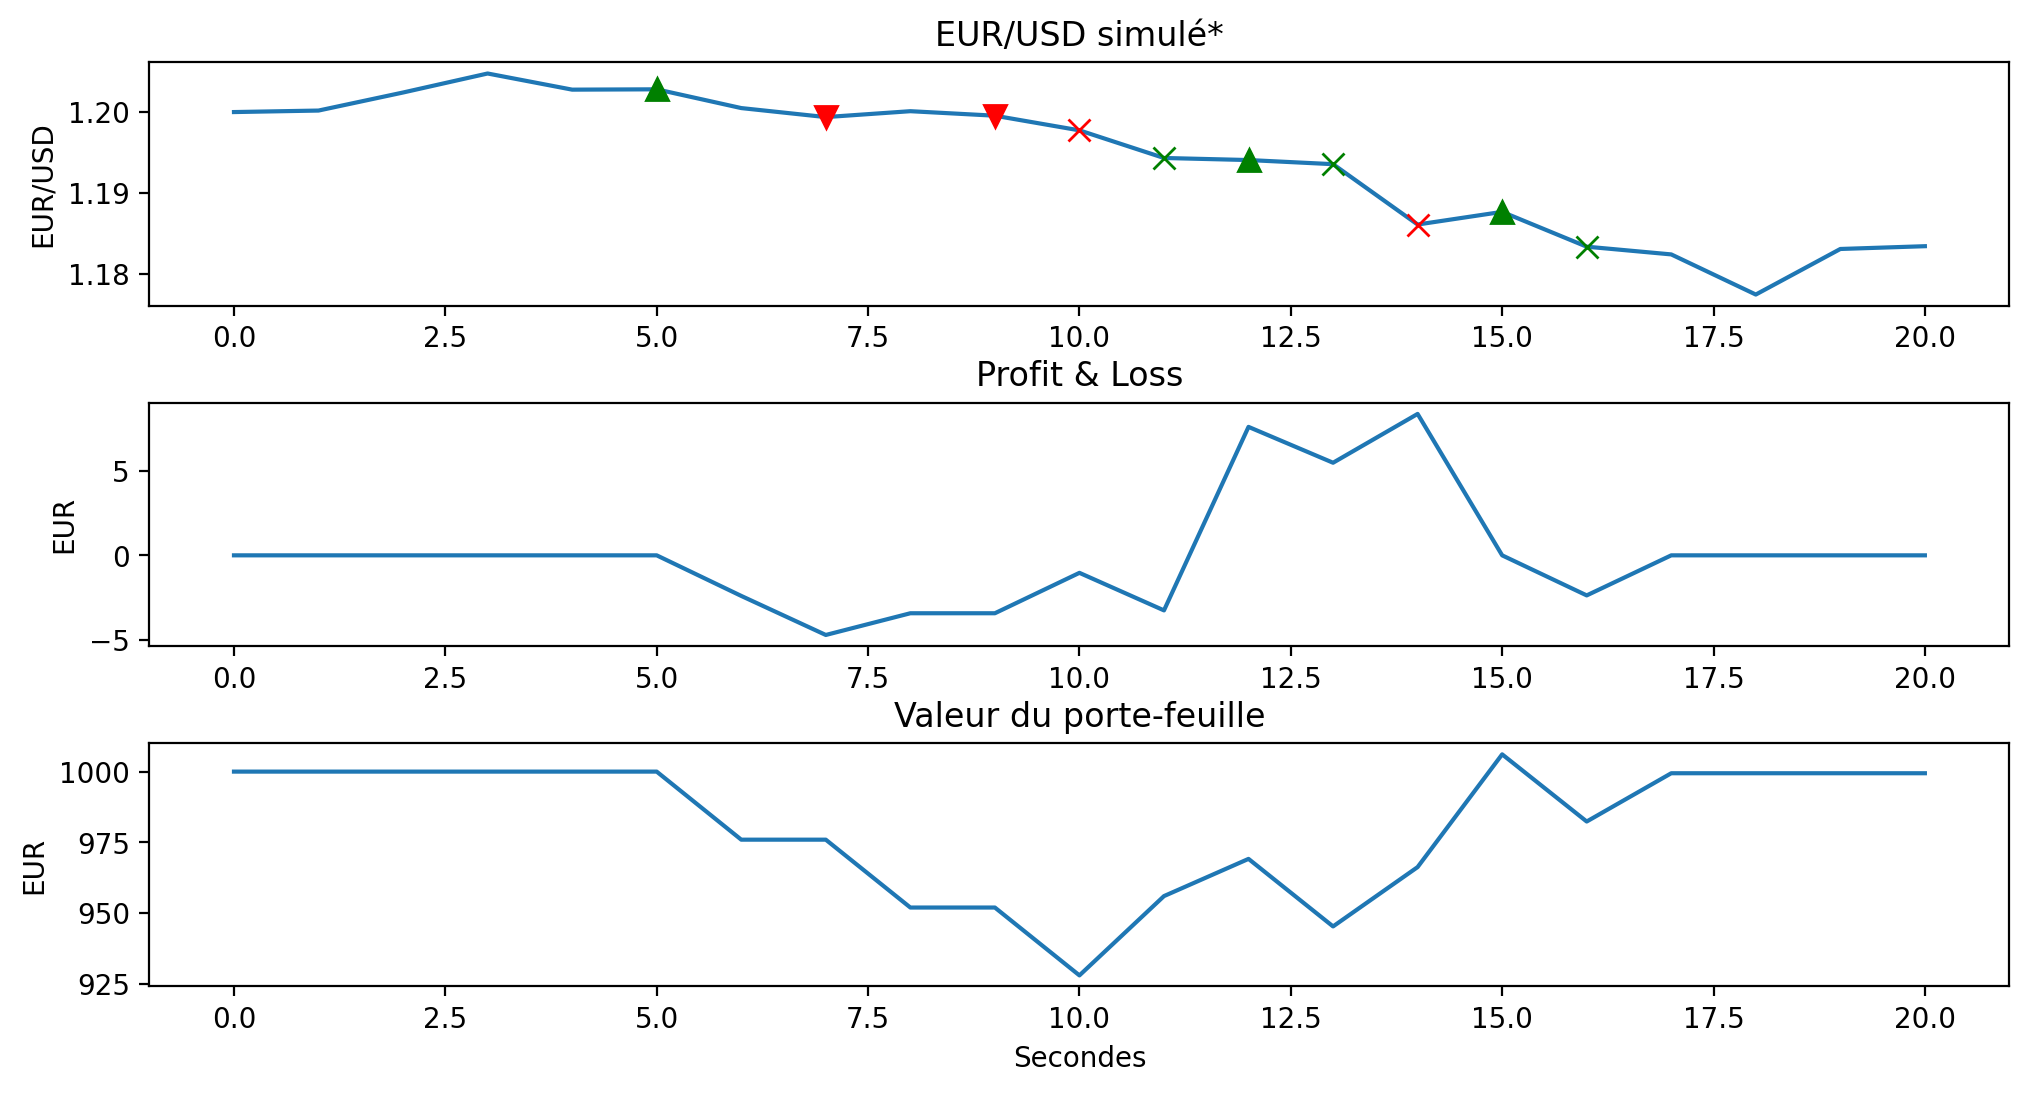

In [35]:


env = EnvTest2()
#agent = Agent()
print(f"env observation spaces : {env.observation_spaces.shape}")
print(f"env action spaces : {env.action_spaces.n}")
print()
num_action = env.action_spaces.n
num_observation = env.observation_spaces.shape[0]

nb_max_episode = 1

for episode in range(nb_max_episode):
    state = env.reset()
    print(f"state : {state}")
    done = False
    score = 0
    compteur = 0
    while not done:
        action = env.action_spaces.sample()
        
        next_state, reward, done, _ = env.step(action)
        print(f"reward : {reward}")

        
        score += reward
        state = next_state
        
        if done:
            env.render()
            #print(f"episode : {episode+1} - score total : {score}")
            pass
        

In [5]:
import csv
from datetime import datetime, timedelta
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

class MarketDataApp(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.order_book = {}

    def error(self, reqId, errorCode, errorString):
        print("Error {}: {}".format(errorCode, errorString))

    def historicalData(self, reqId, bar):
        if bar.date[-8:] == "16:00:00":
            if "BID" not in self.order_book:
                self.order_book["BID"] = {}
            if "ASK" not in self.order_book:
                self.order_book["ASK"] = {}
            self.order_book["BID"][bar.open] = bar.volume
            self.order_book["ASK"][bar.close] = bar.volume

    def get_order_book(self, filename):
        contract = Contract()
        contract.symbol = "EUR"
        contract.secType = "CFD"
        contract.currency = "USD"
        contract.exchange = "SMART"
        end_time = datetime(year=2023, month=2, day=24, hour=14, minute=0, second=0)
        start_time = end_time - timedelta(minutes=1)
        end_time_str = end_time.strftime("%Y%m%d-%H:%M:%S")
        self.reqHistoricalData(1, contract, end_time_str, "1 day", "1 hour", "BID", 1, 1, False, [])
        self.run()
        self.print_order_book(filename)

    def print_order_book(self, filename):
        if not self.order_book:
            print("Error: order book data not available")
            return
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['BID Size', 'Price', 'ASK Size'])
            for price in sorted(self.order_book["BID"], reverse=True):
                bid_size = self.order_book["BID"][price]
                if price in self.order_book["ASK"]:
                    ask_size = self.order_book["ASK"][price]
                else:
                    ask_size = "-"
                writer.writerow([bid_size, price, ask_size])


app = MarketDataApp()
app.connect("127.0.0.1", 7496, 0)
app.get_order_book("eurusd_order_book.csv")
app.disconnect()


Error 502: Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002
Error 504: Not connected
Error: order book data not available
